https://towardsdatascience.com/bayesian-logistic-regression-with-pymc3-8e17c576f31a

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn
import warnings
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
from sklearn.metrics import confusion_matrix

In [2]:
df=pd.read_csv('datatest.txt')
df.sample(5)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
2264,2015-02-04 01:43:00,20.7000,25.075,0.0,515.50,0.003782,0
554,2015-02-02 21:13:00,20.8900,23.000,0.0,485.00,0.003508,0
1357,2015-02-03 10:36:00,21.7900,28.125,499.0,1123.50,0.004541,1
409,2015-02-02 18:48:00,21.7000,24.290,0.0,664.75,0.003896,0
1137,2015-02-03 06:55:59,20.2675,22.840,0.0,439.25,0.003352,0


In [3]:
df['date']=pd.to_datetime(df['date'])

In [4]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000
max,24.408333,31.472500,1697.250000,1402.250000,0.005378,1.000000


In [5]:
df['date'].describe()

/tmp/ipykernel_58308/801468514.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['date'].describe()


count                    2665
unique                   2665
top       2015-02-02 14:19:00
freq                        1
first     2015-02-02 14:19:00
last      2015-02-04 10:43:00
Name: date, dtype: object

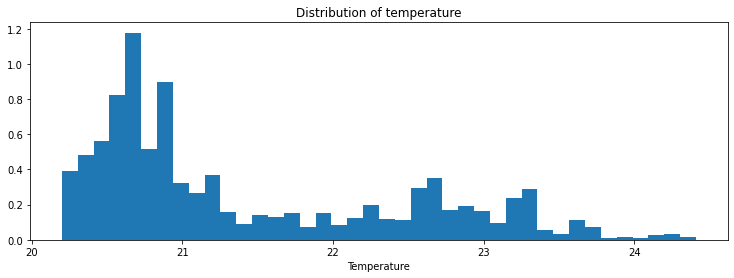

In [6]:
figsize(12.5, 4)
plt.hist(df['Temperature'], bins=40, density=True, label='Temperature')
plt.xlabel('Temperature')
plt.title('Distribution of temperature')
plt.show()

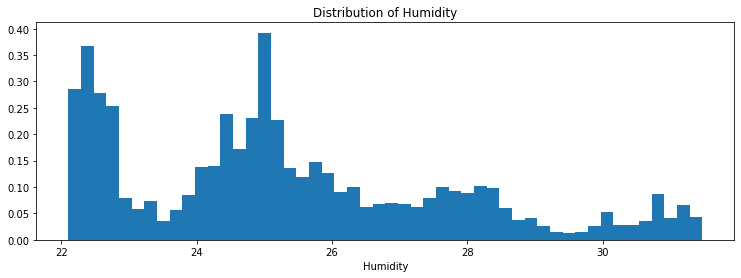

In [7]:
figsize(12.5, 4)
plt.hist(df['Humidity'], bins=50, density=True, label='Humidity')
plt.xlabel('Humidity')
plt.title('Distribution of Humidity')
plt.show()

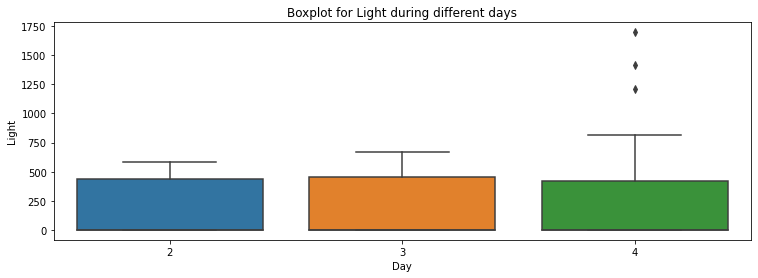

In [8]:
figsize(12.5, 4)
sns.boxplot(x=df['date'].dt.day,y=df['Light'], orient='v')
plt.xlabel('Day')
plt.title('Boxplot for Light during different days')
plt.show()

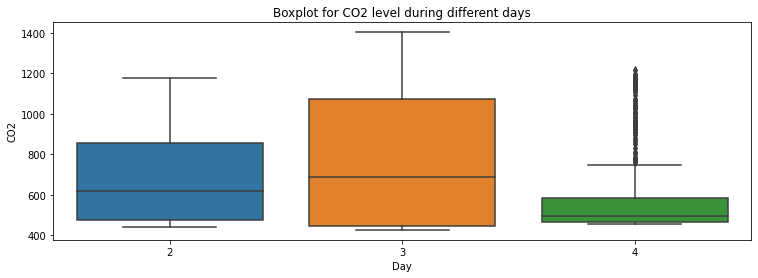

In [9]:
figsize(12.5, 4)
sns.boxplot(x=df['date'].dt.day,y=df['CO2'], orient='v')
plt.xlabel('Day')
plt.title('Boxplot for CO2 level during different days')
plt.show()

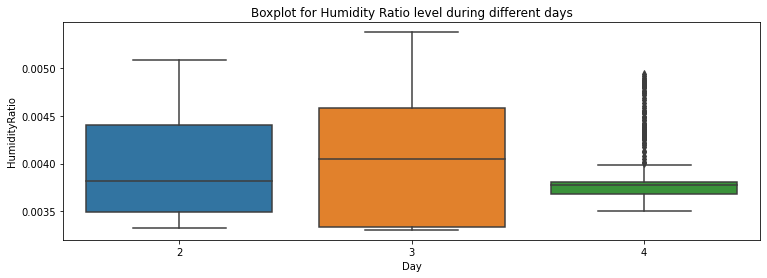

In [10]:
figsize(12.5, 4)
sns.boxplot(x=df['date'].dt.day,y=df['HumidityRatio'], orient='v')
plt.xlabel('Day')
plt.title('Boxplot for Humidity Ratio level during different days')
plt.show()

/home/jay/.virtualenvs/default/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


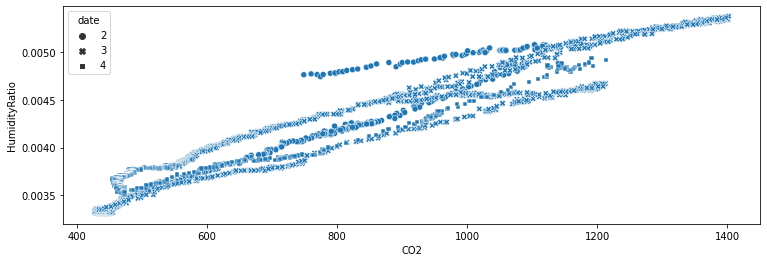

In [11]:
ax=sns.scatterplot(df['CO2'], df['HumidityRatio'], style=df['date'].dt.day)

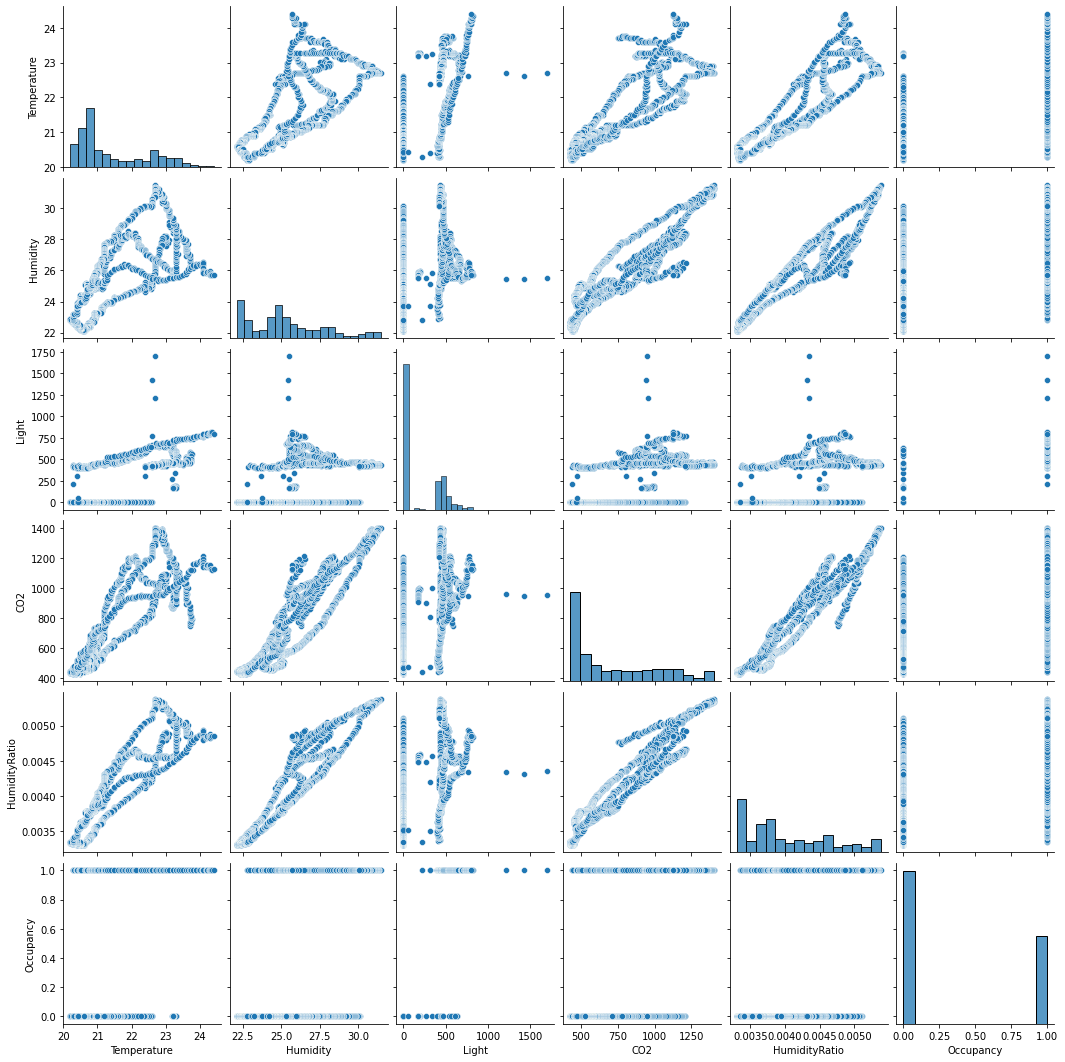

In [12]:
ax=seaborn.pairplot(df)

/tmp/ipykernel_58308/4025557798.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


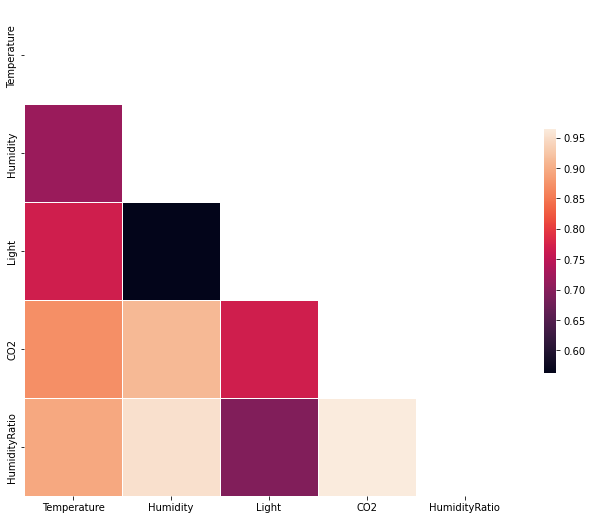

In [13]:
corr=df.iloc[:, 1:-1].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
ax=sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## The Model

In [14]:
lower=-10**6
higher=10**6
with pm.Model() as first_model:
    #priors on parameters
    beta_0=pm.Uniform('beta_0', lower=lower, upper= higher)
    beta_temp=pm.Uniform('beta_temp', lower, higher)
    beta_humid=pm.Uniform('beta_humid', lower, higher)
    beta_light=pm.Uniform('beta_light', lower, higher)
    beta_co2=pm.Uniform('beta_co2', lower, higher)
    beta_humid_ratio=pm.Uniform('beta_humid_ration', lower, higher)
    
    #the probability of belonging to class 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_temp*df['Temperature']+
                               beta_humid*df['Humidity']+
                               beta_light*df['Light']+
                               beta_co2*df['CO2']+
                               beta_humid_ratio*df['HumidityRatio']))
with first_model:
    #fit the data 
    observed=pm.Bernoulli("occupancy", p, observed=df['Occupancy'])
    start=pm.find_MAP()
    step=pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(25000, step=step, start=start)
    burned_trace=trace.sel(draw=slice(15000, None))

/tmp/ipykernel_58308/1565754090.py:25: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace=pm.sample(25000, step=step, start=start)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_0]
>Metropolis: [beta_temp]
>Metropolis: [beta_humid]
>Metropolis: [beta_light]
>Metropolis: [beta_co2]
>Metropolis: [beta_humid_ration]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 427 seconds.


In [15]:
burned_trace=trace.sel(draw=slice(15000, None))

In [19]:
pm.plot_trace(burned_trace)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f4b4fbe6700> (for post_execute):


KeyboardInterrupt: 

In [18]:
burned_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [25]:
burned_trace.posterior['beta_0']

<xarray.DataArray 'beta_0' (chain: 4, draw: 10000)>
array([[-11.10279842, -11.10279842, -11.05233676, ..., -16.65192808,
        -16.65192808, -16.65192808],
       [ -0.39721503,  -0.39721503,  -0.39721503, ...,  -8.42701299,
         -8.42701299,  -8.42701299],
       [ -1.15438241,  -1.15438241,  -1.15438241, ...,  -7.23853123,
         -7.23853123,  -7.23853123],
       [-14.91860319, -14.91860319, -14.91860319, ...,  -9.95961473,
         -9.95961473,  -9.95961473]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 15000 15001 15002 15003 ... 24996 24997 24998 24999

In [45]:
coeffs=['beta_0', 'beta_temp', 'beta_humid', 'beta_light', 'beta_co2', 'beta_humid_ration']
d=dict()
for item in coeffs:
    d[item]=[float(burned_trace.posterior[item].mean().data)]
    
result_coeffs=pd.DataFrame.from_dict(d)    
result_coeffs
#coeff_result=pd.DataFrame(d)    
#coeff_result

,beta_0,beta_temp,beta_humid,beta_light,beta_co2,beta_humid_ration
0,-8.765321,-1.043688,0.77401,0.021336,-0.003772,1829.807801


In [48]:
coeffs=['beta_0', 'beta_temp', 'beta_humid', 'beta_light', 'beta_co2', 'beta_humid_ration']
interval=dict()
for item in coeffs:
    
    interval[item]=az.hdi(burned_trace.posterior, hdi_prob=0.95) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
result_coeffs

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.